## Building a Robot Judge
### Problem Set 1

In [1]:
#*************#
#   imports   #
#*************#

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import spacy

from keras import backend as K
from keras.layers import Input, Dense, Activation
from keras.models import Model
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn import svm
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import GridSearchCV


nlp = spacy.load('en')

Using TensorFlow backend.


### 1.

In [2]:
####################################################################################################
#                                                                                                  #
# Use spaCy to process all cases. Split the documents into sentences and tokens. Compute number    #
# of sentences, words, and letters for each document. Report histograms for these statistics.      #
#                                                                                                  #
####################################################################################################

In [3]:
#****************************#
#   load and prepare cases   #
#****************************#
casesList = os.listdir("cases/")

# only take 1000 for testing purpose (now all)
testNumber = len(casesList)

# create dict for storing properties as follows:
# {"case ID": [case year, # sentences, # words, # letters, # nouns, # verbs, # adjectives]}
casesDict = {caseName: [int(caseName[:4])] for caseName in casesList[:testNumber]}

cases = [nlp(open("cases/" + caseName).read()) for caseName in casesList[:testNumber]]

In [4]:
#*********************#
#   sentence tokens   #
#*********************#
for i, case in enumerate(cases):
    for num, sentence in enumerate(case.sents):
        # not sure if I have to store sentences of each case or what to do after spliting
        # into sentences, but I could do this here...
        pass
    
    casesDict[casesList[i]].append(num)

# print(casesDict)

In [5]:
#*****************************#
#   word tokens and letters   #
#*****************************#
for i, case in enumerate(cases):
    letters = 0
    for num, token in enumerate(case):
        # not sure if I have to store tokens of each case or what to do after spliting
        # into tokens, but I could do this here...
        letters += len(token.text)
    
    casesDict[casesList[i]].append(num)
    casesDict[casesList[i]].append(letters)

# print(casesDict)

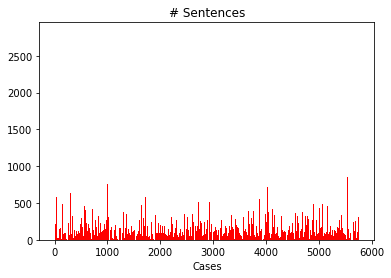

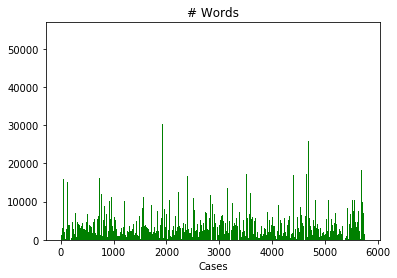

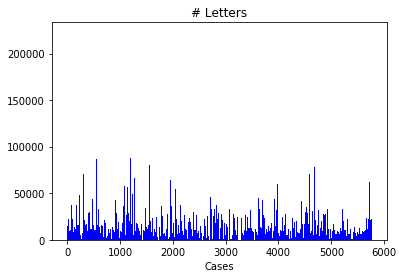

In [6]:
#******************************#
#   histograms of case-stats   #
#******************************#
y = [i+1 for i in range(len(casesDict))]

plt.hist(y, bins=len(casesDict), weights=[casesDict[key][1] for key in casesDict.keys()], 
         color='r', align='mid')
plt.title("# Sentences")
plt.xlabel("Cases")
plt.show()
plt.hist(y, bins=len(casesDict), weights=[casesDict[key][2] for key in casesDict.keys()], 
         color='g', align='mid')
plt.title("# Words")
plt.xlabel("Cases")
plt.show()
plt.hist(y, bins=len(casesDict), weights=[casesDict[key][3] for key in casesDict.keys()], 
         color='b', align='mid')
plt.title("# Letters")
plt.xlabel("Cases")
plt.show()

# I put them seperarly because the # sentences were not visible comparted to # letters
# but one can still compare which sentences have lots of words, which cases use longer wordes, etc.
# (I'll be happy to change it, if it is any inconvenience)

### 2.

In [7]:
####################################################################################################
#                                                                                                  #
# Use the spaCy parts of speech (POS) tags to count number of nouns, verbs, and adjectives in      #
# each document. Visualize POS frequency by year.                                                  #
#                                                                                                  #
####################################################################################################

In [8]:
#*********************************#
#   nouns, verbs and adjectives   #
#*********************************#
for i, case in enumerate(cases):
    nouns = 0
    verbs = 0
    adjectives = 0
    for token in case:
        if token.pos_ == "NOUN":
            nouns += 1
        elif token.pos_ == "VERB":
            verbs += 1
        elif token.pos_ == "ADJ":
            adjectives += 1
    
    casesDict[casesList[i]].append(nouns)
    casesDict[casesList[i]].append(verbs)
    casesDict[casesList[i]].append(adjectives)

# print(casesDict)

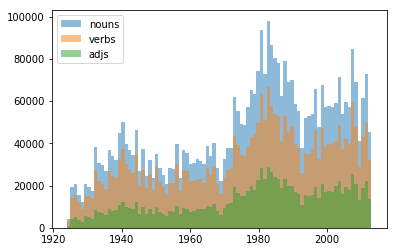

In [9]:
#*************************************#
#   visualize POS frequency by year   #
#*************************************#

# make sure to modify range if new cases/years join
years = [{"noun":0, "verb":0, "adj":0} for i in range(1924, 2014)]

for value in casesDict.values():
    years[value[0]-1924]["noun"] += value[4]   # the case year minus 1924 will give the index
    years[value[0]-1924]["verb"] += value[5]   # representing the actual year
    years[value[0]-1924]["adj"] += value[6]

x = [i for i in range(1924, 2014)]  

plt.hist(x, bins=2014-1924, weights=[years[i]["noun"] for i in range(2014-1924)], 
         alpha=0.5, label='nouns')

plt.hist(x, bins=2014-1924, weights=[years[i]["verb"] for i in range(2014-1924)], 
         alpha=0.5, label='verbs')

plt.hist(x, bins=2014-1924, weights=[years[i]["adj"] for i in range(2014-1924)],
         alpha=0.5, label='adjs')

plt.legend(loc='upper left')
plt.show()

### 3.

In [10]:
####################################################################################################
#                                                                                                  #
# Follow the steps in lecture to normalize your corpus (e.g., removing punctuation) and discuss    #
# your choices about what information to exclude. Using the normalized tokens, make a feature      #
# set of all trigrams that end in a noun.                                                          #
#                                                                                                  #
####################################################################################################

In [11]:
#**********************#
#   normalize corpus   #
#**********************#
normCases = []
for case in cases:
    normCase = ""
    for token in case:
        if token.pos_ == "ADJ":
            normCase += token.text + " "
        elif token.pos_ == "ADV":
            normCase += token.text + " "
        elif token.pos_ == "NOUN":
            normCase += token.text + " "
        elif token.pos_ == "NUM":
            normCase += token.text + " "
        elif token.pos_ == "PROPN":
            normCase += token.text + " "
        elif token.pos_ == "VERB":
            normCase += token.text + " "

    normCases.append(nlp(normCase))
    

# I decided to exclude everything except adjectives, adverbs, noun, numerals, proper nouns 
# and verbs. Of cource the meaning of most legal "memes" will strongly depend on many words 
# that have been excluded with this desicion. But I am convinced that with only the above named 
# words the important meaning of each text isn't lost. And also my computational limit is already 
# at a limit so I rather went for quantity than quality.

# Of course adjectives, verbs and nouns are the most characterizing elements, but the
# adverbs and proper nouns sometimes include important information from which the meaning
# of a sentence greatly depends. Thats why I didn't exlude these.
# The numerals I included, because the magnitude of an expression can in many cases only be
# derived by numbers.

In [12]:
#*************************************************#
#   create set from trigrams that end in a noun   #
#*************************************************#
trigramSet = []

for case in normCases:
    trigrams = []
    for i in range(len(case)):
        if (case[i].pos_ == "NOUN") and (i > 2):
            trigrams.append([case[i-2], case[i-1], case[i]])
            
    trigramSet.append(trigrams)

# print(trigramSet)

### 4.

In [13]:
####################################################################################################
#                                                                                                  #
# Make a dataframe with at least 1000 features (frequencies over trigrams ending in a noun).       #
# Standardize the features to variance one while maintaining sparsity.                             #
#                                                                                                  #
####################################################################################################

In [14]:
#*******************************************************#
#   create dataframe of frequencies over the trigrams   #
#*******************************************************#
freqTrigramSet = []

# I am not sure what frequency the exercise describtion mentions, but the way I understand
# "frequencies over trigrams ending in a noun" is as following (which is probably wrong):
totTrigrams = 0
for case in trigramSet:
    sumTrigrams = len(case)
    freqTrigramSet.append(sumTrigrams)
    totTrigrams += sumTrigrams
    
freqTrigramSet = np.array(freqTrigramSet) / totTrigrams

# standardize to unit variance
freqTrigramSet = (freqTrigramSet - freqTrigramSet.mean()) / freqTrigramSet.std()

# check if unit std deviation/ variance
print(freqTrigramSet.std())


# if the above frequency is not the requested frequency, I'll be happy to chage it...

1.0


In [15]:
#************************#
#   save frequency set   #
#************************#

caseIds = np.array([caseName[5:-4] for caseName in casesList])     # cut-off year and ".txt"

freqTrigramSet = np.column_stack((caseIds[:testNumber], freqTrigramSet))

# uncomment below if frequency set needs to be saved
# np.savetxt('freqTrigramSet.csv', freqTrigramSet, fmt='%s,%s', delimiter=',', 
#            header='caseid,frequency',comments='')

### 5.

In [16]:
####################################################################################################
#                                                                                                  #
# Link the dataframe to the outcome reverse. Create a training set and test set. Train a           #
# LogisticRegression model with default parameters to predict reversal. Compute accuracy and       #
# F1 for the prediction in the training set and in the test set.                                   #
#                                                                                                  #
####################################################################################################

In [17]:
#***********************************************#
#   link the dataframe to the outcome reverse   #
#***********************************************#
reverses = pd.read_csv("case_reversed.csv")
reverses = reverses.set_index('caseid').T.to_dict('list')

correctOrder = []

for case in freqTrigramSet:
    correctOrder.append(reverses[case[0]])

dataSet = np.column_stack((freqTrigramSet, np.array(correctOrder)))

# uncomment below if data set needs to be saved
# np.savetxt('dataSet.csv', dataSet, fmt='%s,%s,%s', delimiter=',', 
#            header='caseid,frequency,case_reversed',comments='')

In [18]:
#**********************************#
#   create training and test set   #
#**********************************#
trainX = dataSet[: int(len(dataSet) * 0.9), 1]
trainY = dataSet[: int(len(dataSet) * 0.9), 2]

testX = dataSet[int(len(dataSet) * 0.9) :, 1]
testY = dataSet[int(len(dataSet) * 0.9) :, 2]

In [19]:
#***********************************************************************************************#
#   define f1 metric                                                                            #
#   (source: https://stackoverflow.com/questions/43547402/how-to-calculate-f1-macro-in-keras)   #
#***********************************************************************************************#
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [20]:
#*******************************#
#   logistic regression model   #
#*******************************#
x = Input((1,))
y = Dense(1)(x)
y = Activation("sigmoid")(y)

model = Model(x, y)
model.compile(loss = "mean_squared_error", optimizer = "adam", metrics = ["accuracy", f1])

# train model
history = model.fit(x = trainX, y = trainY, batch_size = 16, epochs = 100,
                    validation_split=0.2)
# test model
accuracy = model.evaluate(testX, testY, batch_size=16)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 4148 samples, validate on 1037 samples
Epoch 1/100
4148/4148 [==============================] - 0s 100us/step - loss: 0.2582 - acc: 0.5456 - f1: 0.6478 - val_loss: 0.2532 - val_acc: 0.5526 - val_f1: 0.6689
Epoch 2/100
4148/4148 [==============================] - 0s 75us/step - loss: 0.2457 - acc: 0.5846 - f1: 0.7106 - val_loss: 0.2432 - val_acc: 0.5979 - val_f1: 0.7290
Epoch 3/100
4148/4148 [==============================] - 0s 71us/step - loss: 0.2379 - acc: 0.6172 - f1: 0.7503 - val_loss: 0.2380 - val_acc: 0.6152 - val_f1: 0.7519
Epoch 4/100
4148/4148 [==============================] - 0s 56us/step - loss: 0.2342 - acc: 0.6328 - f1: 0.7688 - val_loss: 0.2358 - val_acc: 0.6230 - val_f1: 0.7600
Epoch 5/100
4148/4148 [==============================] - 0s 81us/step - loss: 0.2328 - acc: 0.6336 - f1: 0.7688 - val_loss: 0.2349 - val_acc: 0.6230 - val_f1: 0.7600
E

4148/4148 [==============================] - 0s 62us/step - loss: 0.2319 - acc: 0.6338 - f1: 0.7685 - val_loss: 0.2345 - val_acc: 0.6230 - val_f1: 0.7600
Epoch 47/100
4148/4148 [==============================] - 0s 58us/step - loss: 0.2319 - acc: 0.6338 - f1: 0.7697 - val_loss: 0.2345 - val_acc: 0.6230 - val_f1: 0.7600
Epoch 48/100
4148/4148 [==============================] - 0s 61us/step - loss: 0.2319 - acc: 0.6338 - f1: 0.7688 - val_loss: 0.2345 - val_acc: 0.6230 - val_f1: 0.7600
Epoch 49/100
4148/4148 [==============================] - 0s 54us/step - loss: 0.2319 - acc: 0.6338 - f1: 0.7686 - val_loss: 0.2345 - val_acc: 0.6230 - val_f1: 0.7600
Epoch 50/100
4148/4148 [==============================] - 0s 71us/step - loss: 0.2319 - acc: 0.6338 - f1: 0.7694 - val_loss: 0.2344 - val_acc: 0.6230 - val_f1: 0.7600
Epoch 51/100
4148/4148 [==============================] - 0s 70us/step - loss: 0.2319 - acc: 0.6338 - f1: 0.7697 - val_loss: 0.2344 - val_acc: 0.6230 - val_f1: 0.7600
Epoch 52/10

4148/4148 [==============================] - 0s 56us/step - loss: 0.2319 - acc: 0.6338 - f1: 0.7707 - val_loss: 0.2345 - val_acc: 0.6230 - val_f1: 0.7600
Epoch 96/100
4148/4148 [==============================] - 0s 56us/step - loss: 0.2319 - acc: 0.6338 - f1: 0.7686 - val_loss: 0.2345 - val_acc: 0.6230 - val_f1: 0.7600
Epoch 97/100
4148/4148 [==============================] - 0s 53us/step - loss: 0.2319 - acc: 0.6338 - f1: 0.7679 - val_loss: 0.2344 - val_acc: 0.6230 - val_f1: 0.7600
Epoch 98/100
4148/4148 [==============================] - 0s 53us/step - loss: 0.2319 - acc: 0.6338 - f1: 0.7685 - val_loss: 0.2344 - val_acc: 0.6230 - val_f1: 0.7600
Epoch 99/100
4148/4148 [==============================] - 0s 59us/step - loss: 0.2319 - acc: 0.6338 - f1: 0.7692 - val_loss: 0.2345 - val_acc: 0.6230 - val_f1: 0.7600
Epoch 100/100
577/577 [==============================] - 0s 35us/step


In [21]:
#*************************#
#   get accuracy and F1   #
#*************************#
print("training accuracy:", history.history['val_acc'][-1])
print("test accuracy:", accuracy[1], '\n')

print("training f1:", history.history['val_f1'][-1])
print("test f1:", accuracy[2])

training accuracy: 0.622950819959521
test accuracy: 0.6395147313691508 

training f1: 0.7599550640801455
test f1: 0.7753202577397563


### 6.

In [22]:
####################################################################################################
#                                                                                                  #
# Use GridSearchCV() to choose hyperparameters: L1 vs L2 penalty, and regularization parameter C.  #
# Report the best model parameters and score. Report the ROC Curve and AUC.                        #
#                                                                                                  #
####################################################################################################

In [23]:
#****************************#
#   choose hyperparameters   #
#****************************#

# no idea... 

# (and sadly there are no examples or I couldn't find any 
# on https://github.com/ellliottt/robot_judge_2019/tree/master/notebooks)

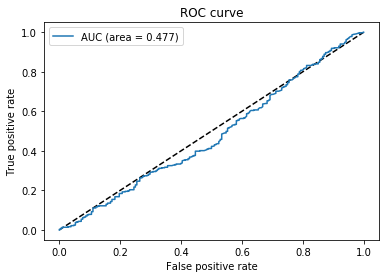

In [24]:
#******************************#
#   report ROC curve and AUC   #
#******************************#
yPred = model.predict(testX).ravel()
yTrue = [int(testY[i]) for i in range(len(testY))]

fpr, tpr, thresholds = roc_curve(yTrue, yPred, pos_label=1)
auc = auc(fpr, tpr)

# plot curve
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='AUC (area = {:.3f})'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

### 7.

In [25]:
####################################################################################################
#                                                                                                  #
# Make a new dataframe where each sentence (of each case) is treated as a separate document.       #
# Compute vader compound sentiment scores for each sentence and report the top 10 highest- and     #
# lowest-sentiment sentences.                                                                      #
#                                                                                                  #
####################################################################################################

In [26]:
#*************************************************#
#   get all sentences and their sentiment score   #
#*************************************************#
sid = SentimentIntensityAnalyzer()

sentences = []

for case in cases:
    for sentence in case.sents:
        sentences.append((sentence, sid.polarity_scores(sentence.text)['compound']))

In [27]:
#*************************************************#
#   report top 10 highest and lowest sentiments   #
#*************************************************#
def sortOnCompound(val): 
    return val[1]

sentences.sort(key=sortOnCompound, reverse=True)

In [28]:
print("10 highest sentiment senentces:" + '\n' + "-------------------------------")
for i in range(10):
    print(str(i+1) + ".) " + str(sentences[i][0]))

10 highest sentiment senentces:
-------------------------------
1.) At the termination of the trust, any and all accrued or undistributed net income, and any proceeds from the investment of such net income, should be deemed and treated as property owned absolutely by Virginia R. Clifford, the beneficiary, as of the time of the termination of the trust, and the remainder of the trust estate should be deemed and treated as property owned by the settlor; that the trustee should have full power and authority to do the following things: "(a) To exercise, or to appoint proxies to exercise, any and all voting powers under any certificates or shares of stock in the trust estate; (b) to retain, or to sell, exchange, mortgage, or pledge any certificates, shares of stock, securities or other items of property or any fractional interest in any of the same now or hereafter in the trust estate, whether as part of the corpus or principal thereof or as investments or proceeds and any income therefrom,

In [29]:
print("\n10 lowest sentiment senentces:" + '\n' + "-------------------------------")
for i in range(1, 11):
    print(str(i) + ".) " + str(sentences[-i][0]))
    
# where number 1 is the lowest score...


10 lowest sentiment senentces:
-------------------------------
1.) Whoever, during and in relation to any crime of violence or drug trafficking crime (including a crime of violence or drug trafficking crime which provides for an enhanced punishment if committed by the use of a deadly or dangerous weapon or device) for which he may be prosecuted in a court of the United States, uses or carries a firearm, shall, in addition to the punishment provided for such crime of violence or drug trafficking crime, be sentenced to imprisonment for five years, and if the firearm is a short-barreled rifle, short-barreled shotgun, or semiautomatic assault weapon, to imprisonment for ten years, and if the firearm is a machinegun, or a destructive device, or is equipped with a firearm silencer or firearm muffler, to imprisonment for thirty years.

2.) Except to the extent that a greater minimum sentence is otherwise provided by this subsection or by any other provision of law, any person who, during and

### 8.

In [30]:
####################################################################################################
#                                                                                                  #
# Use TfidfVectorizer to compute tf-idf frequencies for each sentence, and then compute            #
# cosine similarities between all sentences. Report example pairs of very similar sentences        #
# and very dissimilar sentences.                                                                   #
#                                                                                                  #
####################################################################################################

In [31]:
#**************************************************#
#   compute tf-idf frequencies for each sentence   #
#**************************************************#
sents = []
for case in cases:
    for sentence in case.sents:
        sents.append(sentence.text)

tfIdf = TfidfVectorizer().fit_transform(sents)

In [32]:
#*************************#
#   cosine simularities   #
#*************************#

# I only use 100, because python couldn't/wouldn't handel 1000
simulars = cosine_similarity(tfIdf[:100])

print(simulars)

[[1.         0.         0.         ... 0.         0.         0.        ]
 [0.         1.         0.48109398 ... 0.02411814 0.         0.        ]
 [0.         0.48109398 1.         ... 0.         0.         0.        ]
 ...
 [0.         0.02411814 0.         ... 1.         0.         0.        ]
 [0.         0.         0.         ... 0.         1.         0.04542495]
 [0.         0.         0.         ... 0.         0.04542495 1.        ]]


In [33]:
# what we can see from the above matrix is, that of course a sentence is very similar
# to itself (i.e. the diagonal of the matrix is all ones).

# sentence 1 is very dissimilar to all others (and the other way around of course)
print("sentence 1:", sents[0])

# sentence 2 and 3 are similar (as we can see there was an overcharge and reparation in both)
print("sentence 2:", sents[1])
print("sentence 3:", sents[2])

# whereas 3 and 98 don't have a lot in comon at all
print("sentence 2:", sents[1])
print("sentence 98:", sents[97])

sentence 1:  STONE , Circuit Judge.

sentence 2: This is an action to recover reparation for a freight overcharge.

sentence 3: The matter was first presented to the Interstate Commerce Commission, which found there had been an overcharge and declared reparation.

sentence 2: This is an action to recover reparation for a freight overcharge.

sentence 98: , it becomes such, if it is conditional on performance.



### 9.

In [34]:
####################################################################################################
#                                                                                                  #
# Use k-means clustering to assign the sentences into 20 clusters. List 5 example sentences        #
# from each cluster.                                                                               #
#                                                                                                  #
####################################################################################################

In [35]:
#***************************************#
#   assign sentences into 20 clusters   #
#***************************************#
kmeans = KMeans(n_clusters=20).fit(tfIdf)

In [36]:
clusters = [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]

for i, clus in enumerate(kmeans.labels_.tolist()):
    clusters[clus].append(sents[i])
    
for i in range(20):
    print(len(clusters[i]))
    
# cant list 5 ar moment, but one
for i in range(20):
    print("cluster " + str(i+1) + ":")
    for j in range(1):   # change to 5 if possible
        print(clusters[i][j])

1434
329845
1
221277
29578
1385
13472
1
295451
513
1571
36402
244
1880
2364
25667
3791
4794
1654
13
cluster 1:
The Commission cites Section 1.10 of its Rules and Regulations ( 47 C.F.R. 1.10 ), as follows:
cluster 2:
This is an action to recover reparation for a freight overcharge.

cluster 3:
Due to these circumstances, Howard, Weil has properly conceded that its claim is now moot and that this is not a situation that is an exception to the mootness doctrine.

cluster 4:
The railway having failed to pay the amount found due by the Commission, the present suit resulted.

cluster 5:
50 S. Ct. 422 ,
cluster 6:
See Lahti v. New England Power Ass'n , 1 Cir., 160 F.2d 845, 858 , and Massachusetts Mutual Life Ins.
cluster 7:
Id. at 1034
cluster 8:
It is, of course, the general rule that mandamus may not be substituted for appeal.

cluster 9:
I.
cluster 10:
483 ,
cluster 11:
Zenith Radio Corp. , 475 U.S. 574 , 586 , 106 S.Ct. 1348 , 89
cluster 12:
74 L. Ed. 1051 ; Brewster v. Gage , 280 U. S.